# Bandwith-Evaluation (MESH)

## List of testtraces:
- 09-07-2024-with latency-measurement

### 1. Install dependencies

In [8]:
%%capture
!pip install ipykernel;
!pip install matplotlib;
!pip install seaborn;
!pip install folium;
!pip install plotly;

import pandas as pd;
import geopandas as gpd;
import folium;
import os;
import seaborn as sns;
import plotly.figure_factory as ff;


### 2. Load testtraces

In [9]:
testtraces_a = dict()
# testtraces_b = dict()

# evaluation without latency-check
for dir in os.listdir('../results/mesh'):
    if "a" in dir:
        testtraces_a[dir] = []
        try:
            for file in os.listdir(os.path.join('../results/mesh', dir)):
                if "pcap" not in file:
                    file_path = os.path.join('../results/mesh', dir, file)
                    df = pd.read_csv(file_path)
                    testtraces_a[dir].append(df)
        except Exception as e:
            print(f"Failed to read {file_path}: {e}")


### 3.1. Plotting of bandwith-results depending on distance to center:

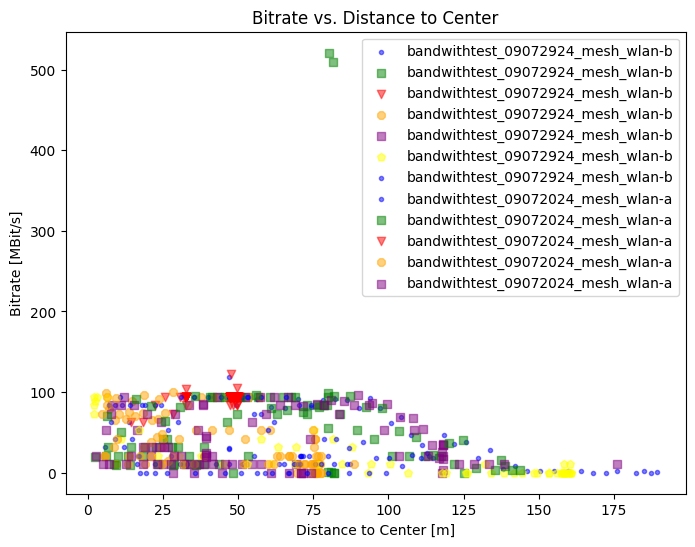

In [10]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.figure(figsize=(8, 6))

colors = ['blue', 'green', 'red', 'orange', 'purple', 'yellow']  # Customize as needed
markers = ['.', ',', 'v', '8', 's', 'p']

for testname, list_of_dfs in testtraces_a.items():
    for i, df in enumerate(list_of_dfs):
        # Choose a color for each DataFrame
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]

        plt.scatter(
            df['DISTANCE_CENTER'], 
            df['Bitrate'],
            marker=marker, 
            color=color, 
            alpha=0.5, 
            label=f'{testname}'
        )
        
    plt.title(f'Bitrate vs. Distance to Center')
    plt.xlabel('Distance to Center [m]')
    plt.ylabel('Bitrate [MBit/s]')

plt.legend()
plt.show()



### 3.2. Plotting of bandwith-results depending on distance to AccessPoint (Rüsthalle):

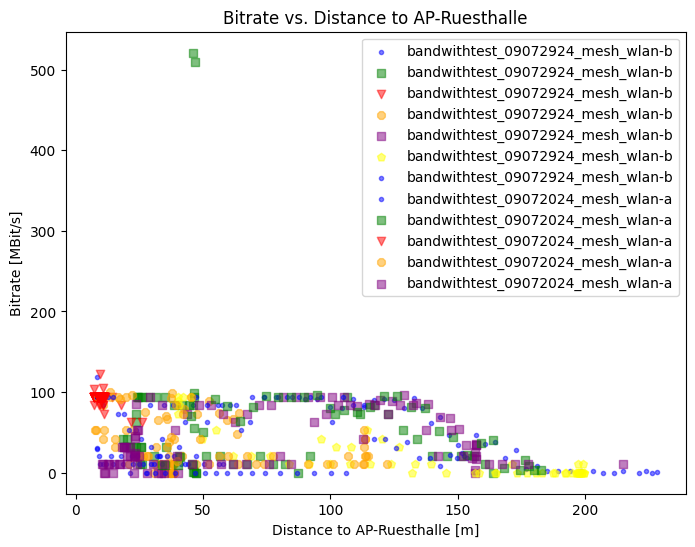

In [11]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.figure(figsize=(8, 6))

colors = ['blue', 'green', 'red', 'orange', 'purple', 'yellow']  # Customize as needed
markers = ['.', ',', 'v', '8', 's', 'p']

for testname, list_of_dfs in testtraces_a.items():
    for i, df in enumerate(list_of_dfs):
        # Choose a color for each DataFrame
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]

        plt.scatter(
            df['DISTANCE_AP_RUESTHALLE'], 
            df['Bitrate'],
            marker=marker, 
            color=color, 
            alpha=0.5, 
            label=f'{testname}'
        )
        
    plt.title(f'Bitrate vs. Distance to AP-Ruesthalle')
    plt.xlabel('Distance to AP-Ruesthalle [m]')
    plt.ylabel('Bitrate [MBit/s]')

plt.legend()
plt.show()

### 3.3. Plotting of bandwith-results depending on distance to AccessPoint (Garage):

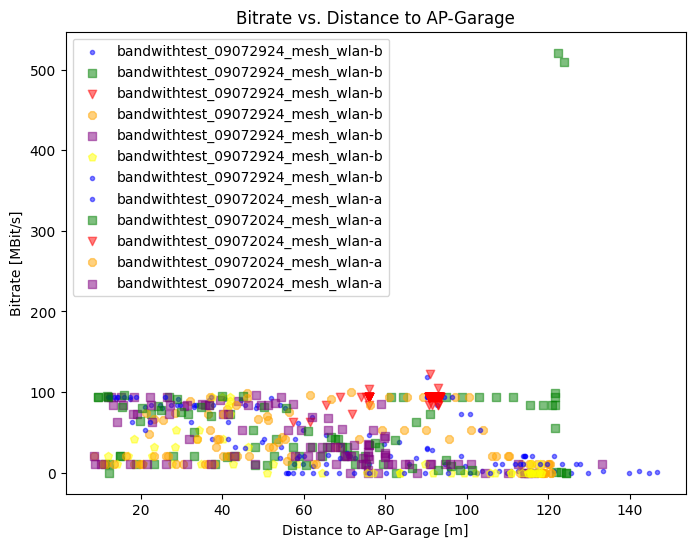

In [12]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.figure(figsize=(8, 6))

colors = ['blue', 'green', 'red', 'orange', 'purple', 'yellow']  # Customize as needed
markers = ['.', ',', 'v', '8', 's', 'p']

for testname, list_of_dfs in testtraces_a.items():
    for i, df in enumerate(list_of_dfs):
        # Choose a color for each DataFrame
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]

        plt.scatter(
            df['DISTANCE_AP_GARAGE'], 
            df['Bitrate'],
            marker=marker, 
            color=color, 
            alpha=0.5, 
            label=f'{testname}'
        )
        
    plt.title(f'Bitrate vs. Distance to AP-Garage')
    plt.xlabel('Distance to AP-Garage [m]')
    plt.ylabel('Bitrate [MBit/s]')

plt.legend()
plt.show()

### 4. Plotting of bandiwth-results on geo-map **_roofmounted-inside_**:

1. Set center of basemap to georeference-point
2. Print colored datapoints from df according to bandwith

In [13]:
from config_mesh import REF_POINT_CENTER, REF_POINT_AP_RUESTHALLE, REF_POINT_AP_GARAGE
from folium import CircleMarker
from branca.colormap import linear

# 0 SCALE_VALUES
MIN_SCALE_BITRATE = 0
MAX_SCALE_BITRATE = 100

# 1. init map at center-georef-point
map_osm = folium.Map(
    location=[REF_POINT_CENTER[0], REF_POINT_CENTER[1]], 
    zoom_start=19,
    )

# add Access-Points
folium.CircleMarker(
    location=[REF_POINT_AP_RUESTHALLE[0], REF_POINT_AP_RUESTHALLE[1]],
    radius=7,  # Adjust the size of the marker as needed
    color='red',
    fill=True,
    fill_opacity=0.7,
).add_to(map_osm)

folium.CircleMarker(
    location=[REF_POINT_AP_GARAGE[0], REF_POINT_AP_GARAGE[1]],
    radius=7,  # Adjust the size of the marker as needed
    color='red',
    fill=True,
    fill_opacity=0.7,
).add_to(map_osm)



# 2. print measurement-points 
color_scale = linear.viridis.scale(MIN_SCALE_BITRATE, MAX_SCALE_BITRATE)

for testname, list_of_dfs in testtraces_a.items():
    for i, df in enumerate(list_of_dfs):
        print(testname)
        for df in list_of_dfs:
            for _, row in df.iterrows():
                folium.CircleMarker(
                    location=[row['Latitude'], row['Longitude']],
                    radius=5,  # Adjust the size of the marker as needed
                    color=color_scale(row['Bitrate']),
                    fill=True,
                    fill_opacity=0.7,
                ).add_to(map_osm)

# Add the color scale legend to the map
color_scale.caption = 'Bitrate [MBit/s]'
map_osm.add_child(color_scale)

map_osm

bandwithtest_09072924_mesh_wlan-b
bandwithtest_09072924_mesh_wlan-b
bandwithtest_09072924_mesh_wlan-b
bandwithtest_09072924_mesh_wlan-b
bandwithtest_09072924_mesh_wlan-b
bandwithtest_09072924_mesh_wlan-b
bandwithtest_09072924_mesh_wlan-b
bandwithtest_09072024_mesh_wlan-a
bandwithtest_09072024_mesh_wlan-a
bandwithtest_09072024_mesh_wlan-a
bandwithtest_09072024_mesh_wlan-a
bandwithtest_09072024_mesh_wlan-a
